In [1]:
library(broom)
library(repr)
library(modelr)
library(tidyverse)
library(ggplot2)
library(glmnet)
library(rsample)


Attaching package: 'modelr'


The following object is masked from 'package:broom':

    bootstrap


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ modelr::bootstrap() masks broom::bootstrap()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8



## Data Desciption

The dataset comprises 607 records detailing salary information for various data science roles, collected across different years, with a focus on 2020 onward. The **work_year** variable captures the specific year in which each salary was recorded. Each job entry is categorized by the **experience_level** of the individual, coded as abbreviations like MI (Mid-Level) and SE (Senior), allowing us to understand the correlation between experience and salary.

The dataset includes **employment_type**, specifying the nature of employment, with entries like FT for full-time roles, which could help in analyzing how job type impacts salary. The **job_title** variable provides a specific role description, such as "Data Scientist" or "Machine Learning Engineer," giving insight into role-based salary differences.

Salaries are reported in their local currency through the **salary_currency** variable, along with a standardized **salary_in_usd** column, which provides a uniform comparison metric across records. **Employee_residence** indicates the country where the individual resides, while **company_location** points to the country where the company operates, allowing a comparison of salary differences across geographic locations and international hiring trends.

Another key feature is **remote_ratio**, which shows the percentage of time an employee works remotely, ranging from 0% (fully on-site) to 100% (fully remote). This can reveal trends in remote work adoption in the data science field and its potential impact on salary. Lastly, **company_size** categorizes employers as Small (S), Medium (M), or Large (L), providing insights into how company size might influence salary levels.

## Question

Can we predict the annual salary (in USD) of a data science professional based on their job title, company location, and remote work ratio?

Response Variable = salary_in_usd  
Explanatory Variables = job_title, company_location, and remote_ratio

This question is focused solely on **prediction**. I am not looking to understand the underlying causes or relationships between these variables and salary but simply want to develop a model that can accurately estimate a data science professional’s salary based on their job title, company location, and work arrangement.

## How Data Will Help

The dataset includes specific information on job titles, company locations, and remote work ratios, which are useful predictors for estimating salaries. By training a predictive model on these variables, I can create a tool that estimates expected salaries based on these inputs. This can help job seekers or companies to predict salaries without needing to know details like experience level or employment type.

## Exploratory Data Analysis and Visualization

In [2]:
ds_salaries = read.csv("data/ds_salaries.csv")
head(ds_salaries)

,X,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
1,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
2,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
3,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
4,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
5,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
6,5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


Removing any irrelevant columns, such as X, which appears to be an index.  
Ensuring that all categorical variables are correctly converted to factors or categorical types.  
Checking for any missing values and deciding on an appropriate imputation or removal strategy if there are any.

**Plot**

To address the question of how experience level, employment type, and remote work ratio affect salaries, I propose creating a box plot of salaries by experience level and employment type. This visualization will allow us to see the salary distribution within each experience level and employment type category, providing insights into the typical salary ranges for different levels.  
Additionally, a scatter plot of salary against remote work ratio can help explore if there's any trend between remote work percentage and salary. A regression line might also be added to observe any linear trend.

**Why**

The box plot is relevant because it visually compares the distribution of salaries within each category, making it easier to spot variations across experience levels and employment types.  
The scatter plot with remote work ratio helps assess if there's any correlation between remote work and salary, addressing one aspect of the question directly.

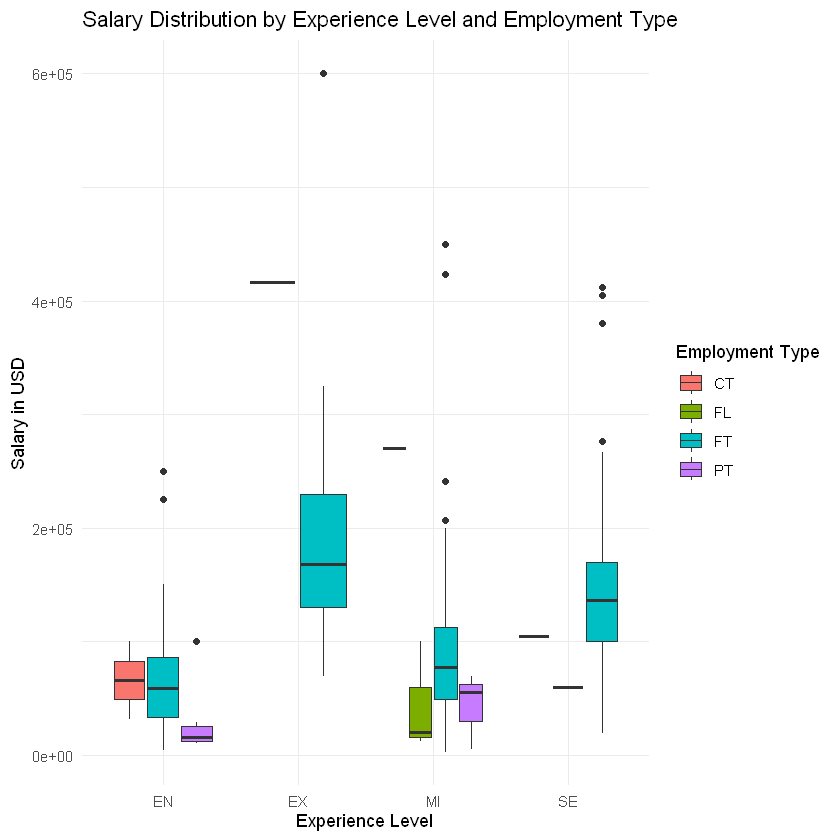

In [3]:
ggplot(ds_salaries, aes(x = experience_level, y = salary_in_usd, fill = employment_type)) +
  geom_boxplot() +
  labs(title = "Salary Distribution by Experience Level and Employment Type",
       x = "Experience Level",
       y = "Salary in USD") +
  theme_minimal() +
  scale_fill_discrete(name = "Employment Type")

Executive (EX) level employees generally have higher salary distributions, particularly in full-time (FT) roles, where the median salary is considerably high. This trend suggests that experience level significantly impacts salary, with executives earning more than mid-level and junior employees.  
Entry (EN) and Mid-Level (MI) employees show lower salary distributions across most employment types, indicating a correlation between lower experience and lower salary.  
Part-time (PT) and freelance (FL) positions have a wider range in salaries at lower experience levels, suggesting variability in compensation for less traditional employment types.

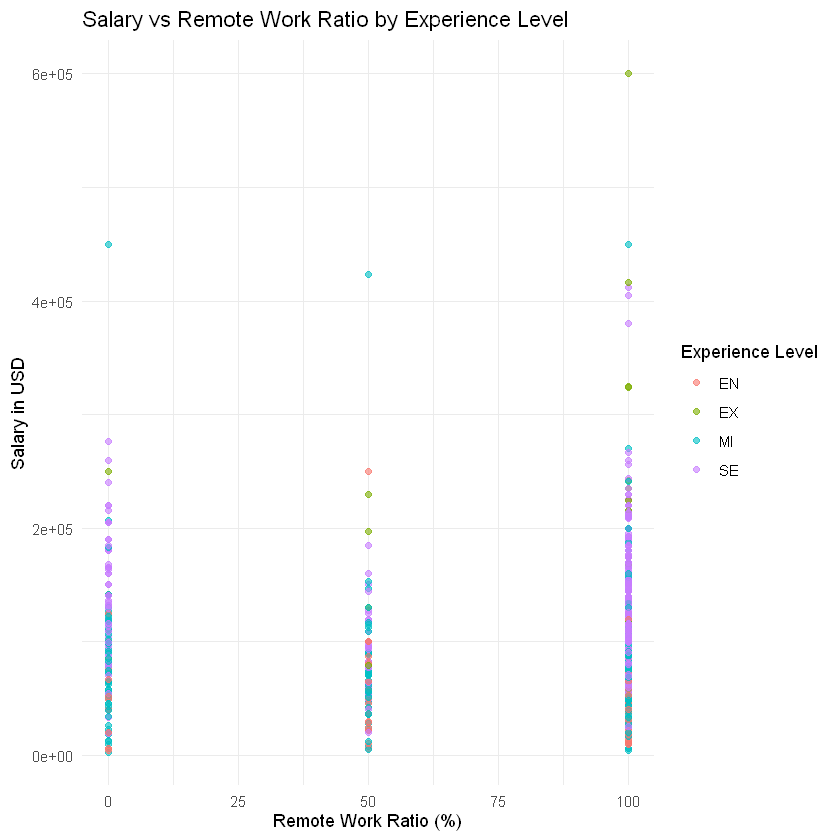

In [4]:
ggplot(ds_salaries, aes(x = remote_ratio, y = salary_in_usd, color = experience_level)) +
  geom_point(alpha = 0.6) +
  labs(title = "Salary vs Remote Work Ratio by Experience Level",
       x = "Remote Work Ratio (%)",
       y = "Salary in USD") +
  theme_minimal() +
  scale_color_discrete(name = "Experience Level")

There is no clear upward or downward trend between salary and remote work ratio across experience levels, suggesting that remote work does not strongly impact salary. Data points are scattered across the remote work spectrum (0%, 50%, 100%) with similar salary distributions.  
Executive level salaries appear consistently high across all remote ratios, while Entry (EN) and Mid-Level (MI) salaries tend to be lower across the board, regardless of remote work percentage.

# Methods and Plan

To address the research question of how job title, company location, and remote work ratio affect salary levels, I propose using a multiple linear regression model. This approach is suitable because the dependent variable, salary, is continuous, and the explanatory variables are a mix of categorical (job title, company location) and continuous (remote work ratio) variables.

**Why is this method appropriate**

Linear regression is widely used for analyzing relationships between a dependent variable and multiple independent variables, making it ideal for understanding the contributions of job title, company location, and remote work ratio to salary levels.  
The model's coefficients will quantify the effect of each explanatory variable on the salary, allowing us to interpret the relative importance of each factor.  
Interaction effects can also be explored, such as the interaction between remote work ratio and company location, to capture nuanced patterns in salary variations.

**Assumptions Required**

1. Linearity: The relationship between the dependent variable (salary) and the explanatory variables must be linear.
2. Independence: Observations in the dataset should be independent of each other.
3. Homoscedasticity: The variance of residuals should be constant across levels of the explanatory variables.
4. Normality: The residuals of the model should follow a normal distribution.
5. Multicollinearity: Explanatory variables should not be highly correlated with each other.

**Potential Limitations or Weaknesses**

1. Data Imbalance: If certain job titles or company locations are underrepresented, the model may struggle to generalize for those categories.
2. Unobserved Variables: Factors such as company size, industry, or individual skills are not included in the model but could significantly influence salary levels.
3. Non-Linearity: Some relationships (e.g., between remote work ratio and salary) may not be purely linear, potentially requiring transformation or alternative models.
4. Categorical Encoding: Handling high cardinality in variables like job title or company location might introduce complexity, requiring techniques like dummy encoding or grouping similar categories.
5. Currency Conversion: If salaries are in different currencies, inconsistent or outdated exchange rates might affect the accuracy of the analysis.

# Implementation of a proposed model

In [5]:
job_title <- as.factor(ds_salaries$job_title)
company_location <- as.factor(ds_salaries$company_location)

In [6]:
model <- lm(salary ~ job_title + company_location + remote_ratio, data = ds_salaries)

In [7]:
summary(model)


Call:
lm(formula = salary ~ job_title + company_location + remote_ratio, 
    data = ds_salaries)

Residuals:
     Min       1Q   Median       3Q      Max 
-2814571   -33375     1932    42590  8713279 

Coefficients:
                                                    Estimate Std. Error t value
(Intercept)                                       -1591216.9   762646.1  -2.086
job_titleAI Scientist                              1604857.2   709669.3   2.261
job_titleAnalytics Engineer                        1663125.8   728078.7   2.284
job_titleApplied Data Scientist                    1685845.2   714108.9   2.361
job_titleApplied Machine Learning Scientist        1688131.7   738280.2   2.287
job_titleBI Data Analyst                           3774847.1   713920.1   5.287
job_titleBig Data Architect                        1595390.4   922500.0   1.729
job_titleBig Data Engineer                         1453648.5   699695.2   2.078
job_titleBusiness Data Analyst                     1490121.5  

In [8]:
remote_group <- cut(
  ds_salaries$remote_ratio,
  breaks = c(-Inf, 25, 50, 75, 100),
  labels = c("0-25%", "26-50%", "51-75%", "76-100%")
)

In [9]:
top_jobs <- ds_salaries %>%
  group_by(job_title) %>%
  summarise(avg_salary = mean(salary, na.rm = TRUE)) %>%
  arrange(desc(avg_salary)) %>%
  slice_head(n = 10) %>%
  pull(job_title)

filtered_data <- ds_salaries %>%
  filter(job_title %in% top_jobs)

There is too much data and it is too complex. After calculating the average salary, only the top ten job_titles are retained.

In [10]:
filtered_data$remote_group <- cut(
  filtered_data$remote_ratio,
  breaks = c(-Inf, 25, 50, 75, 100),
  labels = c("0-25%", "26-50%", "51-75%", "76-100%")
)

summary(filtered_data$remote_group)

0-25%  26-50%  51-75% 76-100% 
     45      36       0     103

In [11]:
summary(filtered_data$remote_ratio)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   50.00  100.00   65.76  100.00  100.00 

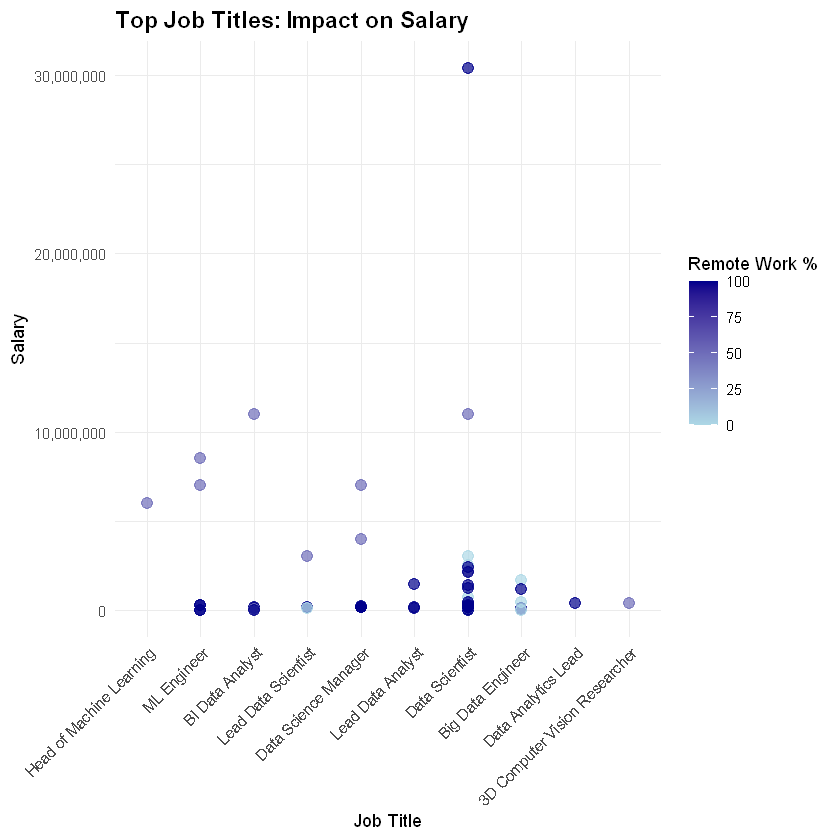

In [12]:
ggplot(filtered_data, aes(x = reorder(job_title, -salary), y = salary, color = remote_ratio)) +
  geom_point(size = 3, alpha = 0.7) +
  scale_color_gradient(low = "lightblue", high = "darkblue", name = "Remote Work %") +
  scale_y_continuous(labels = scales::label_comma()) +
  labs(
    title = "Top Job Titles: Impact on Salary",
    x = "Job Title",
    y = "Salary"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(size = 14, face = "bold")
  )

This plot shows the distribution of salaries across different job titles and the variation in remote work percentage. High-paying roles, such as "Head of Machine Learning," tend to be associated with higher remote work percentages, while lower-paying roles have a more evenly distributed remote work percentage. There are some extremely high salary outliers (e.g., above 20,000,000), which require further validation for accuracy. Overall, the plot highlights a potential correlation between higher remote work percentages and high-paying job titles, providing insights into factors affecting salaries.

In [13]:
ds_salaries <- ds_salaries %>%
  mutate(
    company_location = as.factor(company_location),
    job_title = as.factor(job_title)
  )

In [14]:
X <- model.matrix(~ company_location + job_title + remote_ratio - 1, data = ds_salaries)
Y <- ds_salaries$salary_in_usd
impute_with_mean <- function(data_matrix) {
  for (i in 1:ncol(data_matrix)) {
    if (any(is.na(data_matrix[, i]))) {
      data_matrix[is.na(data_matrix[, i]), i] <- mean(data_matrix[, i], na.rm = TRUE)
    }
  }
  return(data_matrix)
}
X <- impute_with_mean(X)

In [15]:
set.seed(123)
data_split <- initial_split(data.frame(X, Y), prop = 0.8)
train_data <- training(data_split)
test_data <- testing(data_split)

In [16]:
train_x <- as.matrix(train_data[, -ncol(train_data)])
train_y <- train_data[, ncol(train_data)] 
test_x <- as.matrix(test_data[, -ncol(test_data)])
test_y <- test_data[, ncol(test_data)]

In [17]:
print(sum(is.na(X)))
print(sum(is.na(train_x))) 
print(sum(is.na(test_x)))

[1] 0
[1] 0
[1] 0


In [18]:
ridge_model <- cv.glmnet(train_x, train_y, alpha = 0, family = "gaussian")

In [19]:
optimal_lambda <- ridge_model$lambda.min
print(paste("Optimal Lambda:", optimal_lambda))


[1] "Optimal Lambda: 21223.796766718"


In [22]:
ridge_predictions <- predict(ridge_model, s = optimal_lambda, newx = test_x)

rmse <- sqrt(mean((ridge_predictions - test_y)^2))
print(paste("RMSE of the Ridge model:", round(rmse, 2)))
mean_salary <- mean(train_y, na.rm = TRUE)
sd_salary <- sd(train_y, na.rm = TRUE)

print(paste("Mean of target variable:", mean_salary))
print(paste("Standard deviation of target variable:", sd_salary))
print(paste("RMSE as a percentage of the mean:", (rmse / mean_salary) * 100, "%"))

[1] "RMSE of the Ridge model: 58062.1"
[1] "Mean of target variable: 112159.597938144"
[1] "Standard deviation of target variable: 72140.059726308"
[1] "RMSE as a percentage of the mean: 51.7673913668305 %"


In [23]:
lasso_model <- cv.glmnet(
  x = train_x, 
  y = train_y, 
  alpha = 1, 
  family = "gaussian"  
)

In [24]:
optimal_lambda <- lasso_model$lambda.min
print(paste("Optimal Lambda:", optimal_lambda))

[1] "Optimal Lambda: 2678.13940348775"


In [25]:
lasso_predictions <- predict(lasso_model, s = optimal_lambda, newx = test_x)

rmse <- sqrt(mean((lasso_predictions - test_y)^2))
print(paste("RMSE of the Lasso model:", round(rmse, 2)))

[1] "RMSE of the Lasso model: 56172.33"


In [39]:
selected_features <- ds_salaries[, c("company_location", "job_title", "remote_ratio", "salary_in_usd")]

selected_features$company_location <- as.numeric(as.factor(selected_features$company_location))
selected_features$job_title <- as.numeric(as.factor(selected_features$job_title))


In [40]:
correlation_matrix <- cor(selected_features, use = "pairwise.complete.obs")

correlation_melted <- as.data.frame(as.table(correlation_matrix))
colnames(correlation_melted) <- c("Var1", "Var2", "value")

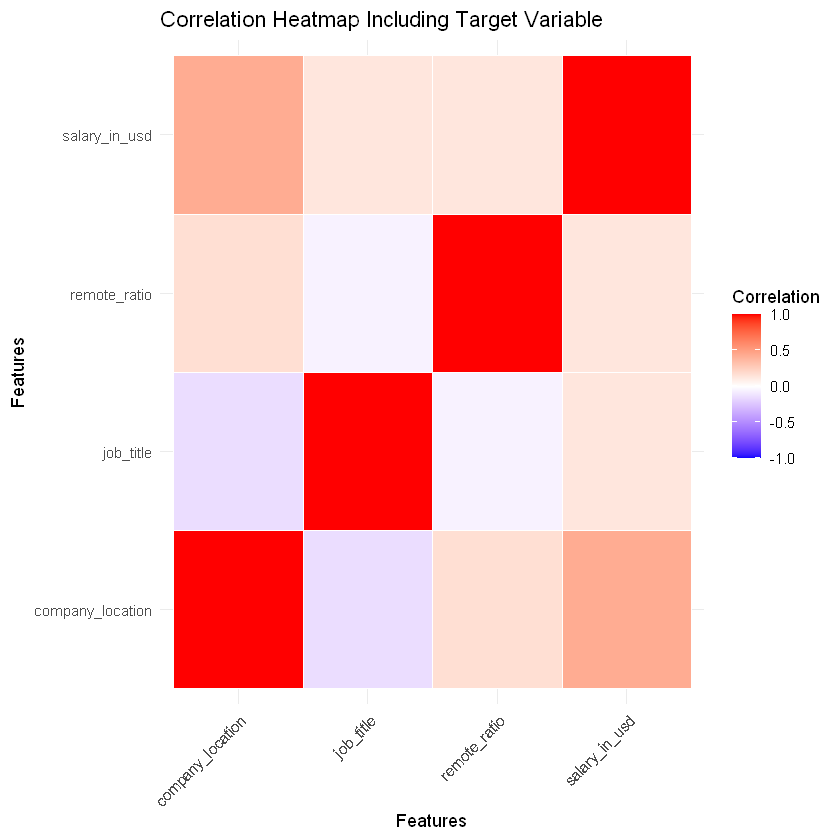

In [41]:
ggplot(data = correlation_melted, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1, 1), space = "Lab",
                       name = "Correlation") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Correlation Heatmap Including Target Variable",
       x = "Features",
       y = "Features")

The variable salary_in_usd shows some positive correlation only with company_location and has low correlation with the other two features. Additionally, both Ridge and Lasso regularization resulted in high RMSE values, indicating that the model is not able to effectively predict salary_in_usd based on company_location, job_title, and remote_ratio. This suggests that these three features may not have a linear relationship with the target variable.

# Conclusion

The heatmap demonstrates that the linear relationships between the features (company_location, job_title, remote_ratio) and the target variable (salary_in_usd) are not significant. The correlation values are relatively weak, with salary_in_usd showing only a mild positive correlation with company_location and very low correlations with the other two features.

Moreover, the results from both Lasso and Ridge regularization yield RMSE values that are excessively high relative to the mean and standard deviation of salary_in_usd. This indicates that the models fail to make accurate predictions of the target variable using the selected features. These findings suggest that company_location, job_title, and remote_ratio may not have sufficient predictive power or linear relationships with salary_in_usd. Other features or nonlinear methods might be required to improve the predictive performance for this dataset.